In [1]:
import pypsa
import pandas as pd
import pypsa
import numpy as np
import os
import matplotlib.pyplot as plt
import glob


run_name = "sectoral_sweeps_all"
csvdir = 'results/'+run_name+'/csvs/'
outdir = "postanalysis/transportsweep/"
figdir = csvdir+outdir
SELECT_RUNS = True
RUNS = ["noscaling","transportsweep"]




In [2]:
# First, just mess around with csvs


def load_data(file):
    csvdir = 'results/'+run_name+'/csvs/'
    data = pd.read_csv(csvdir+file+'.csv',skiprows=lambda x: x in [0,1,2,4])
    data.set_index(list(data.columns[(np.arange(1+sum(["Unnamed" in c for c in list(data.columns)])))]),inplace=True)
    if SELECT_RUNS:
        data = data[[c for c in data.columns if any(n in c for n in RUNS)]]
    return data

def normalize_csv(file):
    #csvdir = 'results/'+run_name+'/csvs/'
    #outdir = "postanalysis/"

    data = pd.read_csv(csvdir+file+'.csv',skiprows=lambda x: x in [0,1,2,4])
    data.set_index(list(data.columns[(np.arange(1+sum(["Unnamed" in c for c in list(data.columns)])))]),inplace=True)
    datanorm = data.divide(data['noscaling'],axis=0)
    if not os.path.exists(os.getcwd()+'/'+csvdir+outdir):
        os.mkdir(os.getcwd()+'/'+csvdir+outdir)
    datanorm.to_csv(csvdir+outdir+file+'_normalized.csv',float_format="%.4f")
    
def aggregate_heat(df,heat_sources):
    #df 
    #heat_sources = ['air heat pump','resistive heater','ground heat pump']
    for s in heat_sources:
        inds = [i for i in df.index if s in i]
        df = pd.concat([df,pd.DataFrame({s : df.loc[inds].sum() }).T],axis=0)
        df = df.drop(inds)
    return df

In [3]:
# Save files with the following csvs, normalized to noscaling scenario

normalize_csv("supply")
normalize_csv("capacities")
normalize_csv("energy")
normalize_csv("costs")


In [4]:
# Aggregate and print total costs

#simple approach
c=load_data("costs")
totc=pd.DataFrame(c.sum())
totc["ratio"] = totc.divide(totc.loc["noscaling"][0],axis=0)
totc.columns = ['total','ratio']
totc.to_csv(csvdir+outdir+"total_costs.csv")

# look at specific sources of costs
neg_costs = c.loc[[i for i in c.index if c.loc[i]["noscaling"]<0]]
#neg_costs = np.round(neg_costs/1e3)

neg_costs.sum()/totc['total']*100

csvdir+outdir+"total_costs.csv"


'results/sectoral_sweeps_all/csvs/postanalysis/transportsweep/total_costs.csv'

In [5]:
# display primary energy use
supplygen = load_data("supply_energy").xs('generators', level=1, drop_level=True)
supplygen = supplygen.droplevel("scale")

supplystore = load_data("supply_energy").xs('stores', level=1, drop_level=True)
supplystore = supplystore.droplevel("scale")
supplystore.index = supplystore.index+" from store"
#drop non energy stores
supplystore = supplystore.loc[[i for i in supplystore.index if not ("co2" in i or "water tank" in i)]]
# keep only non cyclical stores
supplystore = supplystore.loc[[i for i in supplystore.index if abs(supplystore.sum(axis=1)[i])>1]]

supply = pd.concat([supplygen,supplystore],axis=0)

# aggregate solar thermal
st_inds = [i for i in supply.index if "solar thermal" in i]
supply = pd.concat([supply,pd.DataFrame({"solar thermal" : supply.loc[st_inds].sum() }).T],axis=0)
supply = supply.drop(st_inds)
supply.to_csv(csvdir+outdir+"primary_energy.csv") 
supplynorm = supply.divide(supply["noscaling"],axis=0)

supply

,noscaling,transportsweep_1of10,transportsweep_2of10,transportsweep_3of10,transportsweep_4of10,transportsweep_5of10,transportsweep_6of10,transportsweep_8of10,transportsweep_9of10,transportsweep_10of10
offwind-ac,1.201708e+08,1.201508e+08,1.201974e+08,1.201098e+08,1.201484e+08,1.200523e+08,1.200865e+08,1.128471e+08,1.121525e+08,1.121854e+08
offwind-dc,8.488649e+08,8.021149e+08,7.538343e+08,7.175584e+08,6.939535e+08,6.595920e+08,6.101601e+08,5.366308e+08,4.865941e+08,4.304460e+08
onwind,4.226008e+09,4.211006e+09,4.201816e+09,4.185849e+09,4.166567e+09,4.147589e+09,4.128846e+09,4.072170e+09,4.049501e+09,4.032681e+09
ror,1.709144e+08,1.709153e+08,1.709143e+08,1.709131e+08,1.709140e+08,1.709145e+08,1.709158e+08,1.709150e+08,1.709142e+08,1.709146e+08
solar,3.442924e+09,3.406778e+09,3.366273e+09,3.321519e+09,3.267585e+09,3.224484e+09,3.196400e+09,3.146944e+09,3.128634e+09,3.106935e+09
gas,3.634298e+08,3.634298e+08,3.634298e+08,3.634298e+08,3.634298e+08,3.634298e+08,3.634298e+08,3.634298e+08,3.634298e+08,3.634298e+08
solar rooftop,5.570542e+08,5.570551e+08,5.570539e+08,5.570536e+08,5.570539e+08,5.570546e+08,5.570558e+08,5.570551e+08,5.570545e+08,5.570543e+08
oil,2.596537e+00,2.612220e+00,2.882863e+00,2.703783e+00,2.816292e+00,2.510383e+00,2.392266e+00,2.703730e+00,2.225170e+00,2.788406e+00
biogas from store,3.363392e+08,3.363392e+08,3.363392e+08,3.363392e+08,3.363392e+08,3.363392e+08,3.363392e+08,3.363392e+08,3.363392e+08,3.363392e+08
solid biomass from store,1.037595e+09,1.037595e+09,1.037595e+09,1.037595e+09,1.037595e+09,1.037595e+09,1.037595e+09,1.037595e+09,1.037595e+09,1.037595e+09


# TFEC

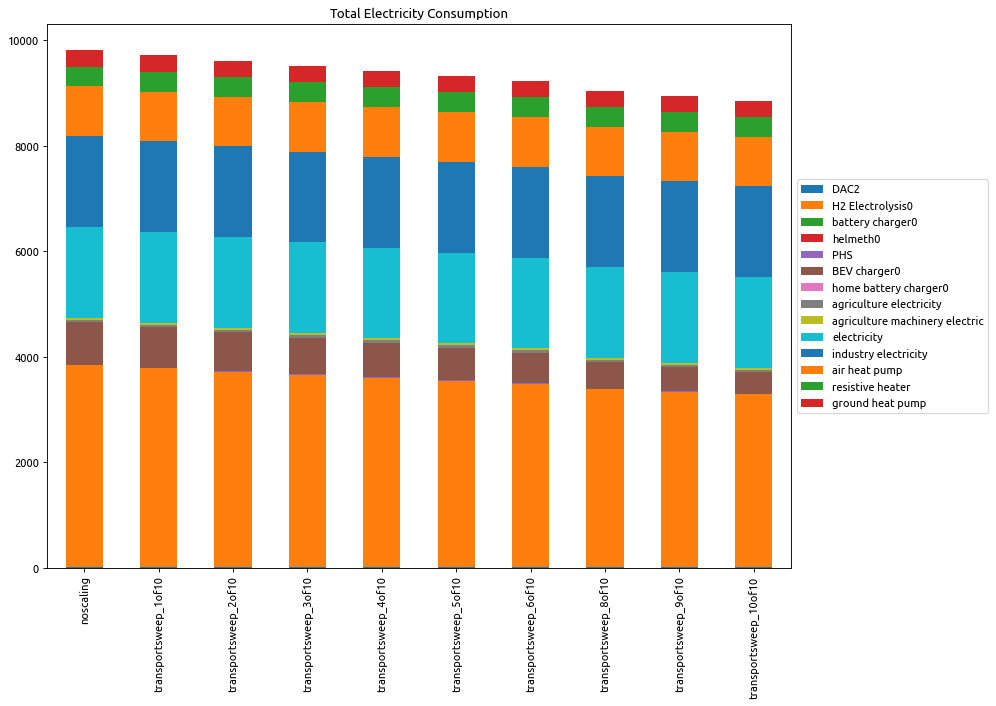

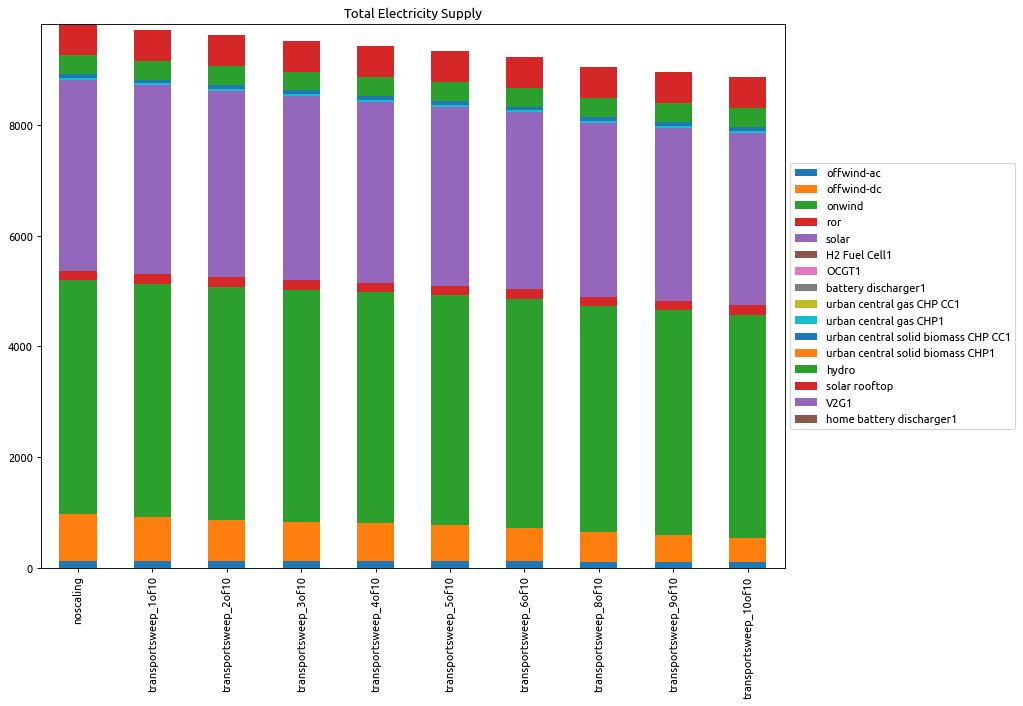

In [480]:
## Electricity Supply and Demand

elec_all = load_data("supply_energy").loc[["AC","low voltage"]]

elec_d = elec_all.loc[[i for i in elec_all.index if elec_all.loc[i]['noscaling']<0]]*-1
elec_d = elec_d.droplevel(["scale","Unnamed: 1"])

elec_s = elec_all.loc[[i for i in elec_all.index if elec_all.loc[i]['noscaling']>0]]
elec_s = elec_s.droplevel(["scale","Unnamed: 1"])


heat_sources = ['air heat pump','resistive heater','ground heat pump']
elec_d = aggregate_heat(elec_d,heat_sources)
elec_d.drop(["electricity distribution grid0","AC1","DC1"],inplace=True) # false variables
elec_d = elec_d/1e6 # convert to TWh

elec_s = elec_s/1e6 # convert to TWh
elec_s.drop(["electricity distribution grid1","AC0","DC0"],inplace=True) # false variable


f1 = plt.figure(figsize=(12, 9), dpi=80)
plt.title('Total Electricity Consumption', color='black')
elec_d.T.plot(kind='bar', stacked=True, ax=f1.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
#ax = elec_d.T.plot.bar(stacked=True)

f2 = plt.figure(figsize=(12, 9), dpi=80)
plt.title('Total Electricity Supply', color='black')
elec_s.T.plot(kind='bar', stacked=True, ax=f2.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


In [481]:
#loads.df.carrier.unique()
#[n for n in nets if any(m in n for m in ["transport","noscaling"])]
tfec_carrier[[c for c in tfec_carrier.columns if "noscaling" in c]]

,noscalings
elec,4259.056451
h2,1065.923801
heat,4277.281936
fuels,2424.382421
total,12026.644609


In [6]:
# Total Final Energy Consumption, grouped by carrier

nets = glob.glob("results/"+run_name+"/postnetworks/*.nc")
nets = [n for n in nets if any(m in n for m in RUNS)]
all_tfec = pd.DataFrame()
for netname in nets:
    n = pypsa.Network(netname)
    name="".join(netname.split("/")[3].split("_")[2:4])
    for c in n.iterate_components(n.branch_components|n.controllable_one_port_components):
        if c.name == "Load":
            loads = c
    loads.pnl.p_set.sum()
    loads.pnl.p
    loads.attrs
    loads.df.carrier.unique()
    
    elec_carriers = ['electricity', 
                     'land transport EV',
                     'industry electricity',
                     'agriculture electricity',
                     'agriculture machinery electric'
                     ]
    
    h2_carriers = ['land transport fuel cell',
                   'H2 for shipping',
                   'H2 for industry'
                  ]
    
    heat_carriers = ['residential rural heat', 
                     'services rural heat',
                     'residential urban decentral heat',
                     'services urban decentral heat', 
                     'urban central heat',
                     'agriculture heat',
                     'low-temperature heat for industry'
                     ]
    
    fuels_carriers = ['solid biomass for industry', 
                      'gas for industry',
                      'naphtha for industry', 
                      'kerosene for aviation'
                     ]
    
    biofuels_carriers = []
    bunker_carriers = []


    all_loads = pd.DataFrame(loads.pnl.p.multiply(n.snapshot_weightings["stores"],axis=0).sum())
    all_loads.columns = ['net demand']

    all_loads = pd.concat([all_loads,pd.DataFrame(loads.df.carrier)],axis=1)
    elec_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in elec_carriers]]
    h2_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in h2_carriers]]
    heat_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in heat_carriers]]
    fuels_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in fuels_carriers]]
    #bunker_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in bunker_carriers]]
    #ag_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in ag_carriers]]

    tfec = pd.DataFrame([elec_loads.sum(),h2_loads.sum(),heat_loads.sum(),fuels_loads.sum()],\
                       index = ["elec","h2","heat","fuels"]).drop(columns="carrier")/1e6
    tfec.columns=[name]
    all_tfec = pd.concat([all_tfec,tfec],axis=1)

    
colsort = [c for c in all_tfec.columns.sort_values() if not "10of10" in c and not "noscaling" in c]
col0 = [c for c in all_tfec.columns.sort_values() if "noscaling" in c]
colend = [c for c in all_tfec.columns.sort_values() if  "10of10" in c ]
colsort = col0+colsort+colend
all_tfec = all_tfec[colsort]

tfec_carrier = all_tfec.copy(deep=True)
#tfec_carrier=all_tfec[[all_tfec.columns.sort_values()[-1]]+list(all_tfec.columns.sort_values()[1:-1])+[all_tfec.columns.sort_values()[0]]].copy(deep=True)
tfec_carrier.loc["total"] = tfec_carrier.sum()
tfec_carrier.to_csv(csvdir+outdir+"/TFEC_by_carrier.csv")

tfec_carrier_norm = tfec_carrier.divide(tfec_carrier["noscalings"],axis=0)
tfec_carrier_norm.to_csv(csvdir+outdir+"/TFEC_by_carrier_pctchange.csv")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 0], imported network file PyPSA version [0, 19, 3].

INFO:pypsa.io:Imported network elec_sc_transportsweep_1of10_s_64_lvopt__25H-T-H-B-I-A-seq2e8_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 0], imported network file PyPSA version [0, 19, 3].

INFO:pypsa.io:Imported network elec_sc_transportsweep_5of10_s_64_lvopt__25H-T-H-B-I-A-seq2e8_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from

In [483]:
# Total Final Energy Consumption, grouped by sector
#nets = glob.glob("results/"+run_name+"/postnetworks/*.nc")
all_tfec = pd.DataFrame()
for netname in nets:
    n = pypsa.Network(netname)
    name="".join(netname.split("/")[3].split("_")[2:4])
    for c in n.iterate_components(n.branch_components|n.controllable_one_port_components):
        if c.name == "Load":
            loads = c
    loads.pnl.p_set.sum()
    loads.pnl.p
    loads.attrs
    loads.df.carrier.unique()
    
    elec_carriers = ['electricity']
    
    transport_carriers = ['land transport fuel cell','land transport EV']
    
    bld_carriers = ['residential rural heat', 
                    'services rural heat',
                    'residential urban decentral heat',
                    'services urban decentral heat', 
                    'urban central heat']
    
    ind_carriers = ['solid biomass for industry', 
                    'gas for industry',
                    'H2 for industry',
                    'naphtha for industry',
                    'low-temperature heat for industry', 
                    'industry electricity']
    
    bunker_carriers = ['kerosene for aviation',
                       'H2 for shipping']
    
    ag_carriers = ['agriculture electricity', 
                   'agriculture heat',
                   'agriculture machinery electric']

    all_loads = pd.DataFrame(loads.pnl.p.multiply(n.snapshot_weightings["stores"],axis=0).sum())
    all_loads.columns = ['net demand']

    all_loads = pd.concat([all_loads,pd.DataFrame(loads.df.carrier)],axis=1)
    elec_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in elec_carriers]]
    transport_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in transport_carriers]]
    bld_heat_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in bld_carriers]]
    ind_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in ind_carriers]]
    bunker_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in bunker_carriers]]
    ag_loads = all_loads.loc[[i for i in all_loads.index if all_loads.loc[i]["carrier"] in ag_carriers]]

    tfec = pd.DataFrame([elec_loads.sum(),transport_loads.sum(),bld_heat_loads.sum(),ind_loads.sum(),bunker_loads.sum(),ag_loads.sum()],\
                       index = ["other elec","transport","heat","industry","bunkers","ag"]).drop(columns="carrier")/1e6
    tfec.columns=[name]
    all_tfec = pd.concat([all_tfec,tfec],axis=1)

colsort = [c for c in all_tfec.columns.sort_values() if not "10of10" in c and not "noscaling" in c]
col0 = [c for c in all_tfec.columns.sort_values() if "noscaling" in c]
colend = [c for c in all_tfec.columns.sort_values() if  "10of10" in c ]
colsort = col0+colsort+colend
all_tfec = all_tfec[colsort]
   
tfec_sector = all_tfec.copy(deep=True)

#tfec_sector=all_tfec[[all_tfec.columns.sort_values()[-1]]+list(all_tfec.columns.sort_values()[1:-1])+[all_tfec.columns.sort_values()[0]]].copy(deep=True)
tfec_sector.loc["total"] = tfec_sector.sum()
tfec_sector.to_csv(csvdir+outdir+"/TFEC_by_sector.csv")

tfec_sector_norm = tfec_sector.divide(tfec_sector["noscalings"],axis=0)
tfec_sector_norm.to_csv(csvdir+outdir+"/TFEC_by_sector_pctchange.csv")

INFO:pypsa.io:Imported network elec_sc_transportsweep_1of10_s_64_lvopt__25H-T-H-B-I-A-seq2e8_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_sc_transportsweep_5of10_s_64_lvopt__25H-T-H-B-I-A-seq2e8_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_sc_noscaling_s_64_lvopt__25H-T-H-B-I-A-seq2e8_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_sc_transportsweep_3of10_s_64_lvopt__25H-T-H-B-I-A-seq2e8_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_sc_transportsweep_8of10_s_64_lvopt__25H-T-H-B-I-A-seq2e8_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported net

In [484]:
tfec_sector_norm

,noscalings,transportsweep1of10,transportsweep2of10,transportsweep3of10,transportsweep4of10,transportsweep5of10,transportsweep6of10,transportsweep8of10,transportsweep9of10,transportsweep10of10
other elec,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
transport,1.0,0.951152,0.902303,0.853455,0.804607,0.755759,0.706910,0.609214,0.560366,0.511517
heat,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
industry,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
bunkers,1.0,0.979037,0.958074,0.937111,0.916148,0.895185,0.874222,0.832296,0.811333,0.790370
ag,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
total,1.0,0.993581,0.987161,0.980742,0.974323,0.967903,0.961484,0.948646,0.942226,0.935807


# PLOTS

In [485]:
# code taken from plot_summary.py, for correct colors

# color=[snakemake.config['plotting']['tech_colors'][i] for i in new_index]
import yaml

configdir = 'results/'+run_name+'/configs/'
#config = yaml.safe_load()
with open(configdir+"config.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

config['plotting']['tech_colors']['AC']='b'
config['plotting']['tech_colors']['DC']='r'
config['plotting']['tech_colors']['electricity distribution grid']='k'
    
preferred_order = pd.Index([
    "transmission lines",
    "hydroelectricity",
    "hydro reservoir",
    "run of river",
    "pumped hydro storage",
    "solid biomass",
    "biogas",
    "onshore wind",
    "offshore wind",
    "offshore wind (AC)",
    "offshore wind (DC)",
    "solar PV",
    "solar thermal",
    "solar rooftop",
    "solar",
    "building retrofitting",
    "ground heat pump",
    "air heat pump",
    "heat pump",
    "resistive heater",
    "power-to-heat",
    "gas-to-power/heat",
    "CHP",
    "OCGT",
    "gas boiler",
    "gas",
    "natural gas",
    "helmeth",
    "methanation",
    "hydrogen storage",
    "power-to-gas",
    "power-to-liquid",
    "battery storage",
    "hot water storage",
    "CO2 sequestration"
])

def make_new_index(index):
    return preferred_order.intersection(index).append(index.difference(preferred_order))    


In [486]:
tfec = tfec_sector_norm
tfec

,noscalings,transportsweep1of10,transportsweep2of10,transportsweep3of10,transportsweep4of10,transportsweep5of10,transportsweep6of10,transportsweep8of10,transportsweep9of10,transportsweep10of10
other elec,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
transport,1.0,0.951152,0.902303,0.853455,0.804607,0.755759,0.706910,0.609214,0.560366,0.511517
heat,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
industry,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
bunkers,1.0,0.979037,0.958074,0.937111,0.916148,0.895185,0.874222,0.832296,0.811333,0.790370
ag,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
total,1.0,0.993581,0.987161,0.980742,0.974323,0.967903,0.961484,0.948646,0.942226,0.935807


In [487]:
# Graph showing total capcities installed vs TFEC

cost = pd.read_csv(csvdir+outdir+"total_costs.csv",index_col=0)

caps = load_data("capacities")#pd.read_csv(csvdir+"capacities.csv",index_col=[0,1],skiprows=lambda x: x in [0,1,2,4])
caps.drop(('stores','oil'),axis=0,inplace=True)

caps.loc["stores"].loc["gas"] = caps.loc["stores"].loc["gas"] + caps.loc["generators"].loc["gas"]
caps.drop(('generators','gas'),axis=0,inplace=True)

caps=caps.droplevel(0)
#caps.index
caps = caps.drop([i for i in caps.index if " water tanks " in i])
caps=aggregate_heat(caps,['solar thermal','gas boiler','resistive heater','air heat pump','water tanks','ground heat pump'])
caps = caps.divide(caps['noscaling'],axis=0)
#caps.index
caps.to_csv(csvdir+outdir+"capacities_agg_normed.csv")


In [488]:
caps.columns
#tfec[pd.Series(caps.columns)]

Index(['noscaling', 'transportsweep_1of10', 'transportsweep_2of10',
       'transportsweep_3of10', 'transportsweep_4of10', 'transportsweep_5of10',
       'transportsweep_6of10', 'transportsweep_8of10', 'transportsweep_9of10',
       'transportsweep_10of10'],
      dtype='object')

In [489]:
maxdiff = max(1-tfec.loc['total'])
#maxdiff = 0.4
spacing =maxdiff/5
if spacing < 0.02:
    spacing = 0.01
elif spacing < 0.05:
    spacing = 0.02
elif spacing < 0.1:
    spacing = 0.05
else:
    spacing = 0.1
    
xt = pd.Series(np.arange(0,maxdiff,spacing))

xt


0    0.00
1    0.01
2    0.02
3    0.03
4    0.04
5    0.05
6    0.06
dtype: float64

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



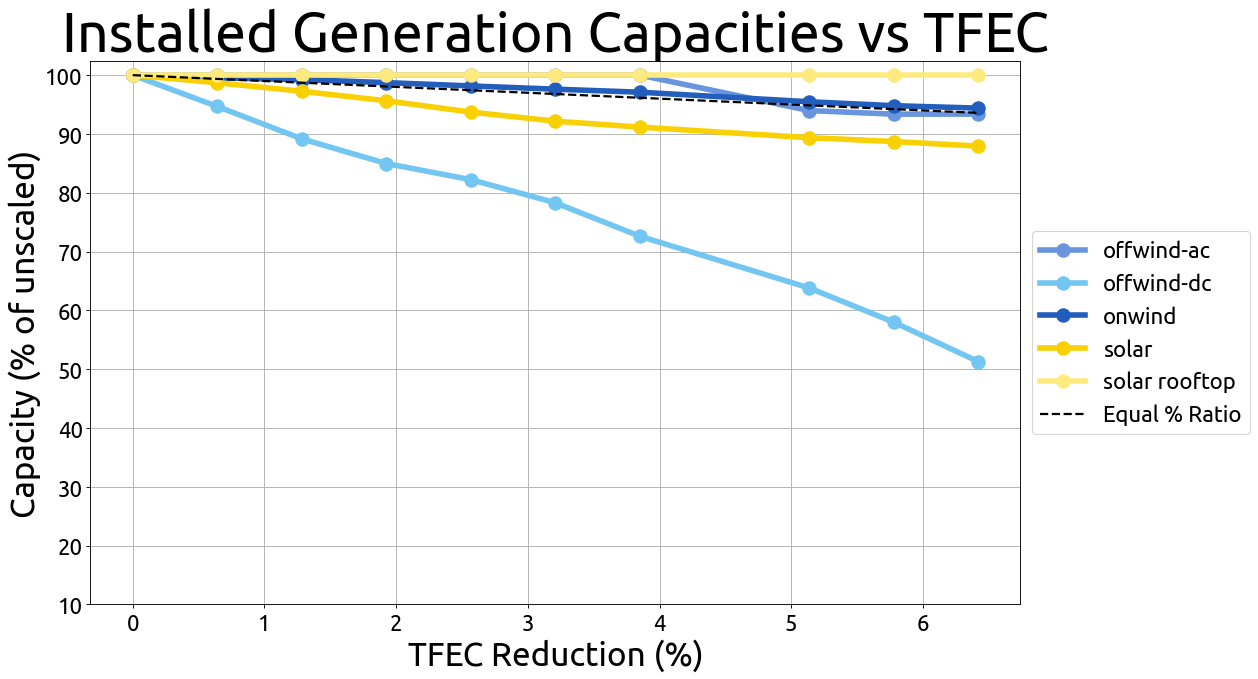

In [490]:
f3, ax = plt.subplots(figsize=(15, 9), dpi=80)

gentechs = [
                'offwind-ac',
                'offwind-dc',
                'onwind',
                'solar',
                'solar rooftop'
            ]
heattechs = [
                'solar thermal',
                'gas boiler',
                'air heat pump',
                'ground heat pump',
                'resistive heater'
            ]
storetechs = [
                'battery',
                'home battery',
                'water tanks'
            ]
h2techs = [
            'H2 Electrolysis',
            'H2 pipeline'
            ]

fueltechs = [
            'oil',
            'gas',
            'biogas',
            'solid biomass'
            ]

transtechs = [
                'AC',
                'DC',
                'electricity distribution grid',
                'H2 pipeline'
              ]

chemtechs = [
            'Fischer-Tropsch',
            'H2 Electrolysis',
            'Sabatier',
            #'',
            #'',
            #'',
            ]

for t in gentechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[gentechs]))),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)


#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])


ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Generation Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(visible=True)

f3.savefig(figdir+'gen.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



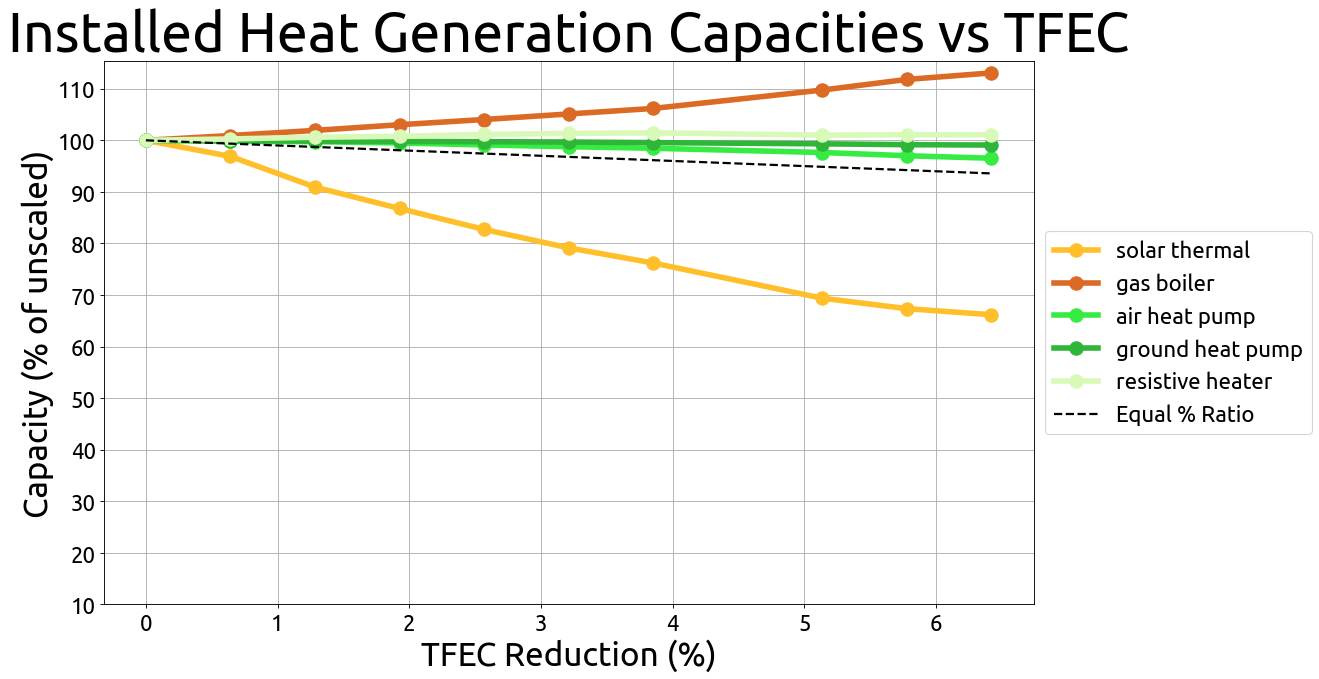

In [491]:
f4, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in heattechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[heattechs])),1),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Heat Generation Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f4.savefig(figdir+'heat.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



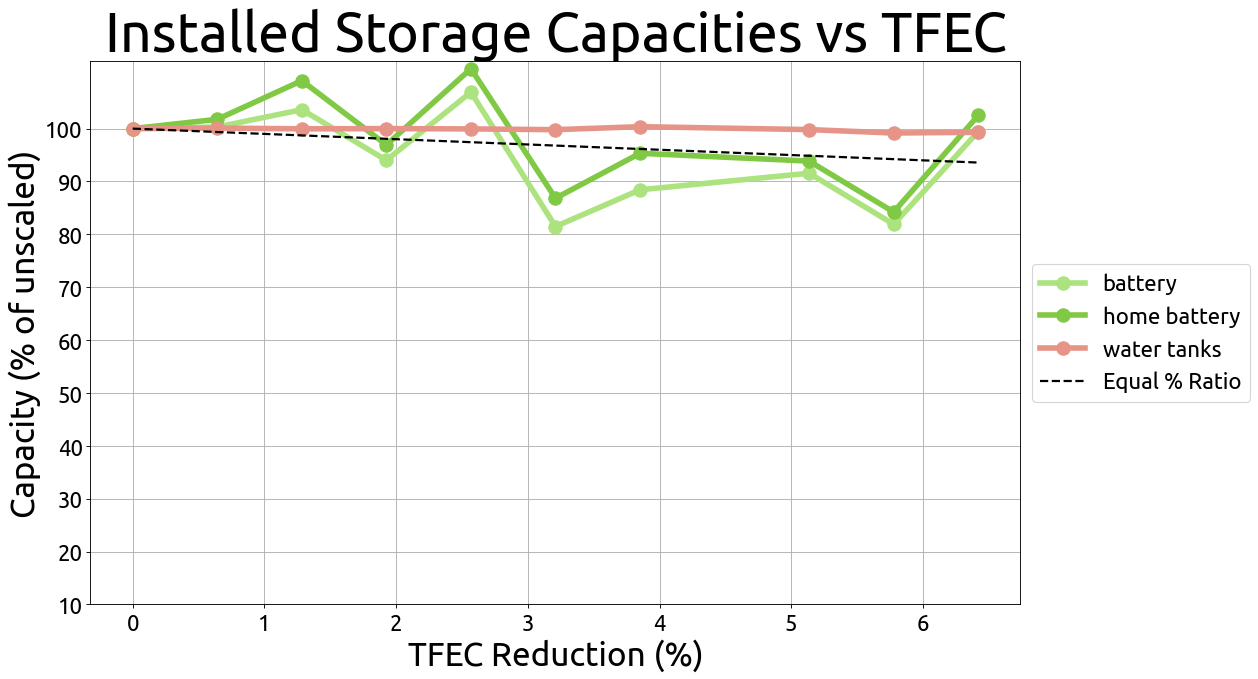

In [492]:
f5, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in storetechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[storetechs]))),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Storage Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f5.savefig(figdir+'store.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



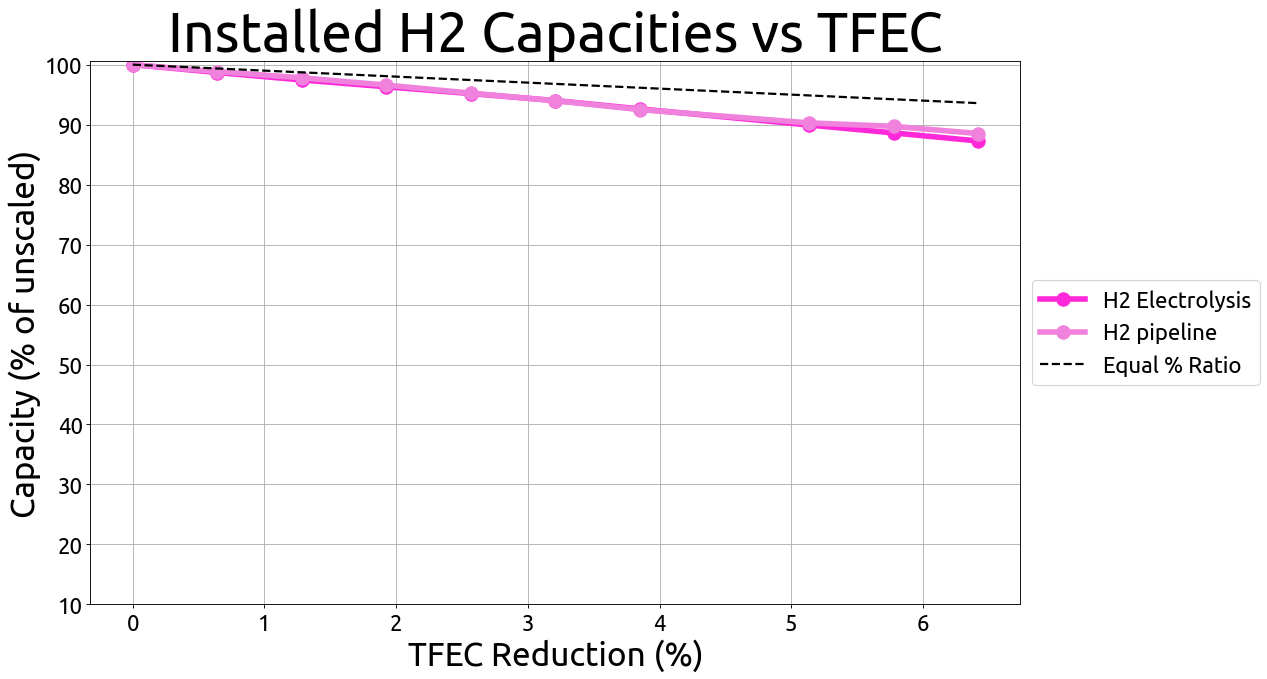

In [493]:
f6, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in h2techs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[h2techs]))),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed H2 Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f6.savefig(figdir+'h2.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



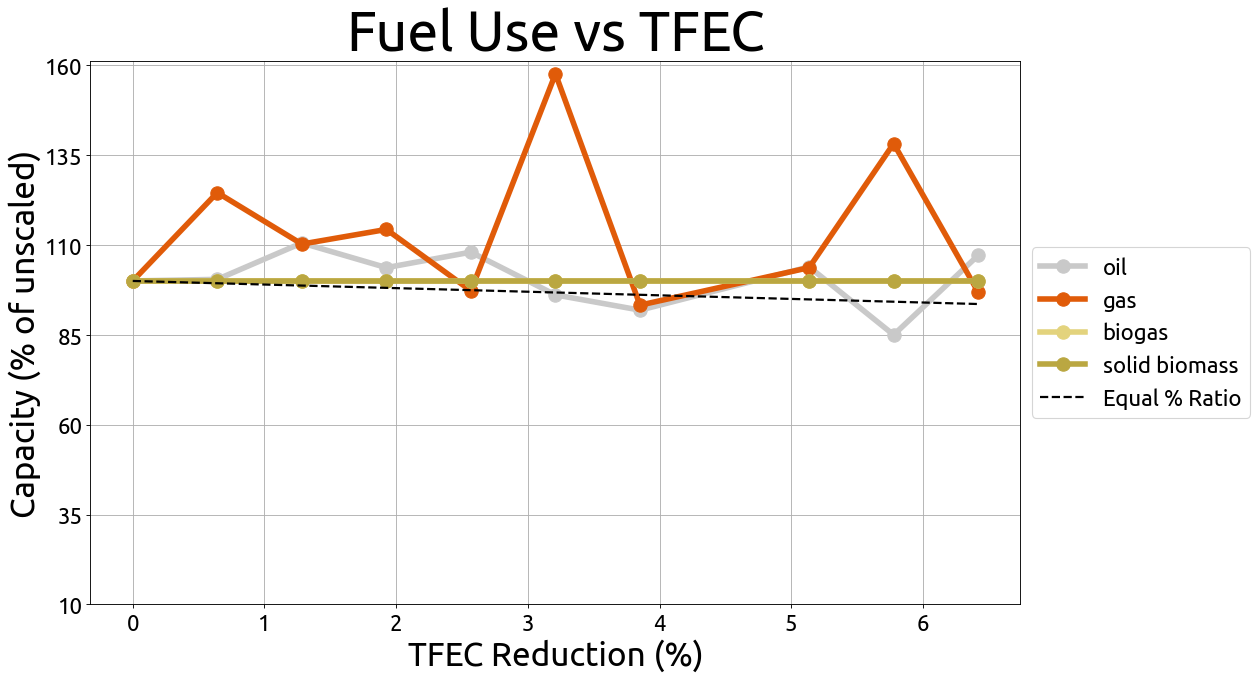

In [494]:
f7, ax = plt.subplots(figsize=(15, 9), dpi=80)

for t in fueltechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[fueltechs])),1),0,-0.25))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Fuel Use vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f7.savefig(figdir+'fuel.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



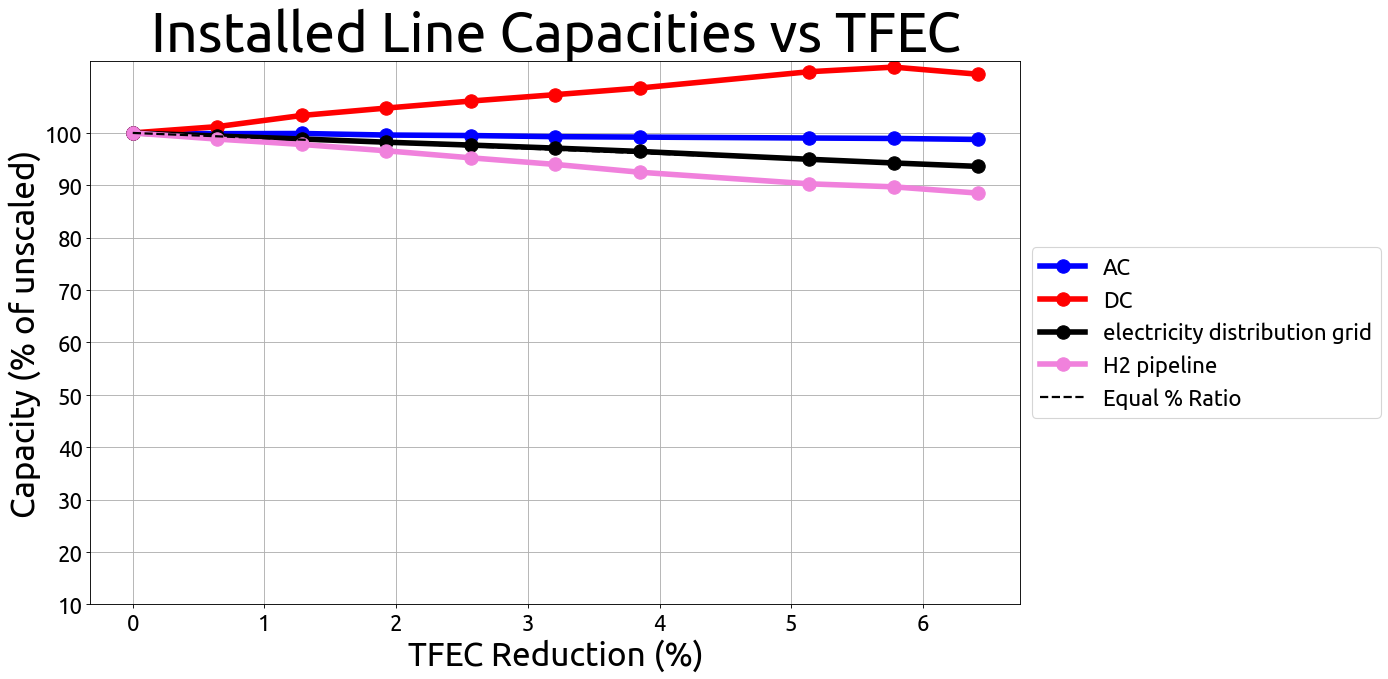

In [495]:
f8, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in transtechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[transtechs]))),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Line Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f8.savefig(figdir+'t_and_d.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



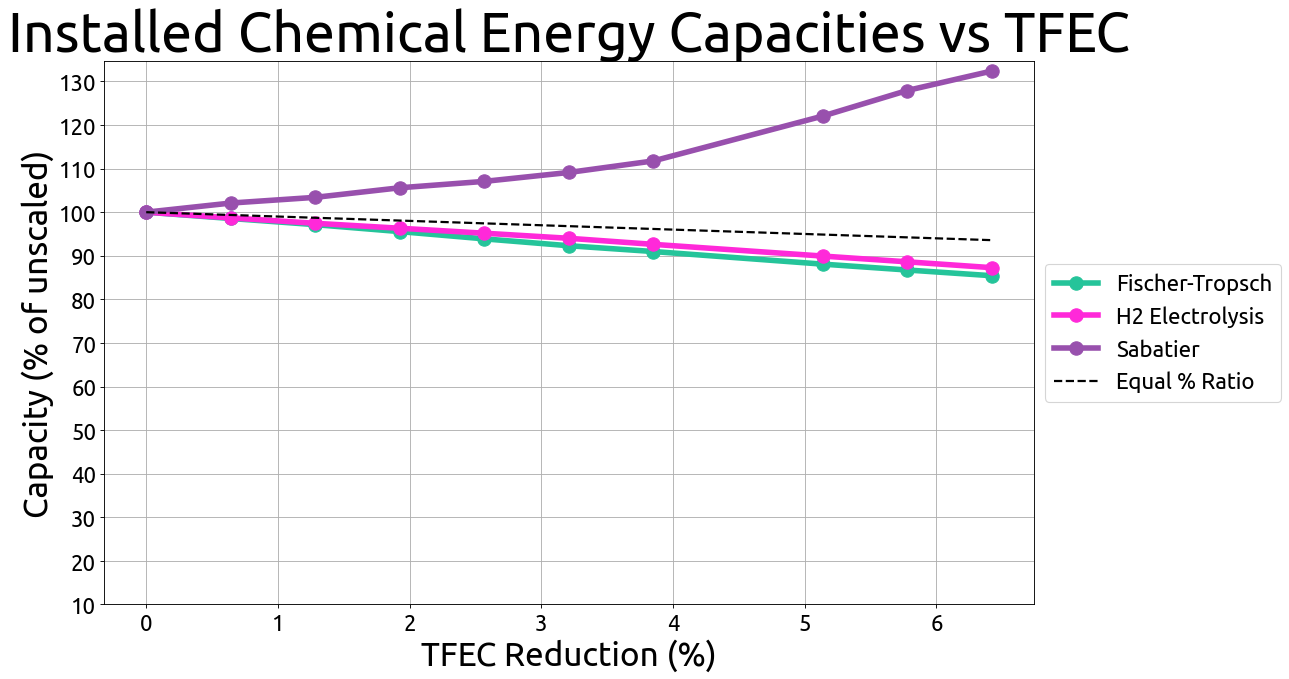

In [496]:
f9, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in chemtechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[chemtechs])),1),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Chemical Energy Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f9.savefig(figdir+'chem.png', bbox_inches='tight')

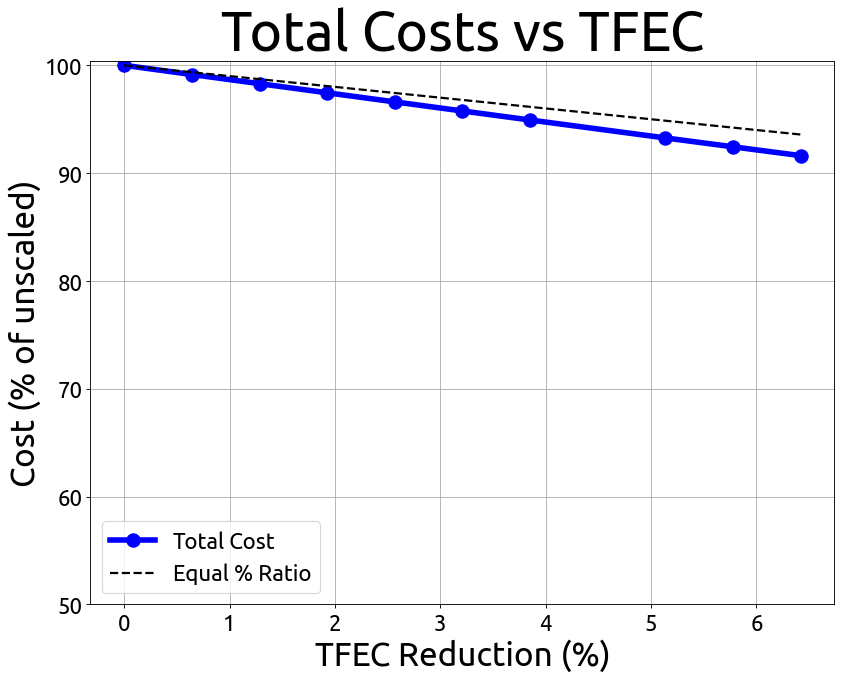

In [497]:
# Graph showing total costs vs TFEC

cost = pd.read_csv(csvdir+outdir+"total_costs.csv",index_col=0)
tfec = pd.read_csv(csvdir+outdir+"TFEC_by_carrier_pctchange.csv",index_col=0)

fc, ax = plt.subplots(figsize=(12, 9), dpi=80)
#f3 = plt.figure(figsize=(12, 9), dpi=80)
ax.set_title('Total Costs vs TFEC', color='black')
#elec_s.T.plot(kind='bar', stacked=True, ax=f2.gca())

ax.plot(1-tfec.loc['total'],cost['ratio'],'bo-', label='Total Cost', linewidth=5,markersize=12)
ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

#ax.set(title='Total Costs vs TFEC', xlabel='Total Costs vs TFEC', ylabel='Total System Costs (% of unscaled system)');

ax.set_ylabel('Cost (% of unscaled)', fontsize=30)
yt = pd.Series([1,0.9,0.8,0.7,0.6,0.5])
ax.set_yticks(yt, (100*yt).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Total Costs vs TFEC', fontsize=50)
ax.legend(prop={'size': 20})
ax.grid(visible=True)



#fig.legend(['Total Cost','Equal % Change'],loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.show()
fc.savefig(figdir+'costs.png', bbox_inches='tight')


# NODAL ANALYSIS

In [955]:
# Graph showing total capcities installed vs TFEC

ncaps = pd.read_csv(csvdir+"nodal_capacities.csv",index_col=[0,1,2],skiprows=lambda x: x in [0,1,2,4])
ncaps

#ncaps.drop(('stores','oil'),axis=0,inplace=True)
ncaps=ncaps.droplevel(0)
#caps.index
ncaps = ncaps.drop([i for i in caps.index if " water tanks " in i])
#ncaps=aggregate_heat(caps,['solar thermal','gas boiler','resistive heater','air heat pump','water tanks','ground heat pump'])
ncaps = ncaps.divide(ncaps['noscaling'],axis=0)
#caps.index



ncaps.index = ncaps.index.swaplevel()
ncaps=ncaps.sort_index(level=0)
ncaps.to_csv(csvdir+outdir+"capacities_nodal_agg_normed.csv")

ncaps

noscaling  Tango_1of10  \
AC                                   NaN          1.0     0.946322   
BEV charger                          AL1 0        1.0     1.000000   
                                     AT1 0        1.0     1.000000   
                                     BA1 0        1.0     1.000000   
                                     BE1 0        1.0     1.000000   
...                                               ...          ...   
urban central water tanks discharger RO1 0        1.0     0.552756   
                                     RS1 0        1.0     0.659676   
                                     SE2 0        1.0     0.894228   
                                     SI1 0        1.0     0.849192   
                                     SK1 0        1.0     0.733055   

                                            Tango_2of10  Tango_3of10  \
AC                                   NaN       0.905855     0.829550   
BEV charger                          AL1 0     1.000000     1.000000   
                                     AT1 0     1.000000     1.000000   
                                     BA1 0     1.000000     1.000000   
                                     BE1 0     1.000000     1.000000   
...                                                 ...          ...   
urban central water tanks discharger RO1 0     0.582027     0.497726   
                                     RS1 0     0.583919     0.613937   
                                     SE2 0     0.627807     0.407068   
                                     SI1 0     0.784808     0.659456   
                                     SK1 0     0.595778     0.558340   

                                            Tango_4of10  Tango_5of10  \
AC                                   NaN       0.763255     0.702238   
BEV charger                          AL1 0     1.000000     1.000000   
                                     AT1 0     1.000000     1.000000   
                                     BA1 0     1.000000     1.000000   
                                     BE1 0     1.000000     1.000000   
...                                                 ...          ...   
urban central water tanks discharger RO1 0     0.467812     0.426192   
                                     RS1 0     0.612182     0.594021   
                                     SE2 0     0.400476     0.302211   
                                     SI1 0     0.414420     0.371582   
                                     SK1 0     0.406530     0.346002   

                                            Tango_6of10  Tango_7of10  \
AC                                   NaN       0.680675     0.653452   
BEV charger                          AL1 0     1.000000     1.000000   
                                     AT1 0     1.000000     1.000000   
                                     BA1 0     1.000000     1.000000   
                                     BE1 0     1.000000     1.000000   
...                                                 ...          ...   
urban central water tanks discharger RO1 0     0.384570     0.314497   
                                     RS1 0     0.535686     0.472608   
                                     SE2 0     0.275011     0.309162   
                                     SI1 0     0.327441     0.341233   
                                     SK1 0     0.299496     0.275553   

                                            Tango_8of10  Tango_9of10  \
AC                                   NaN       0.626731     0.592349   
BEV charger                          AL1 0     1.000000     1.000000   
                                     AT1 0     1.000000     1.000000   
                                     BA1 0     1.000000     1.000000   
                                     BE1 0     1.000000     1.000000   
...                                                 ...          ...   
urban central water tanks discharger RO1 0     0.146286     0.125992   
                                

In [964]:
elec_d

,noscaling,Tango_1of10,Tango_2of10,Tango_3of10,Tango_4of10,Tango_5of10,Tango_6of10,Tango_7of10,Tango_8of10,Tango_9of10,Tango_10of10
H2 Electrolysis0,3741.309735,3507.269450,3300.246959,3141.143488,2909.795530,2703.677265,2499.918955,2283.039407,2030.182285,1735.970259,1483.271334
battery charger0,0.006509,0.005143,0.004212,0.004281,0.004076,0.002267,0.002736,0.002278,0.002417,0.002568,0.002358
helmeth0,0.000328,0.000238,0.000198,0.000248,0.000214,0.000128,0.000154,0.000123,0.000118,0.000132,0.000093
PHS,4.552645,4.467689,4.375951,3.973825,4.024265,3.720477,3.756136,3.724249,3.507858,3.546719,3.113666
BEV charger0,816.663208,776.861269,736.925918,696.989898,657.117144,617.234848,577.377229,537.528868,497.678129,457.911264,418.094911
home battery charger0,0.005232,0.004144,0.003338,0.003395,0.003260,0.001794,0.002148,0.001795,0.001926,0.002030,0.001891
agriculture electricity,44.861105,42.955552,41.049998,39.144445,37.238891,35.333338,33.427784,31.522231,29.616677,27.711124,25.805571
agriculture machinery electric,37.125395,35.226220,33.327045,31.427870,29.528695,27.629520,25.730345,23.831170,21.931995,20.032819,18.133644
electricity,1720.706142,1660.416203,1600.126265,1539.836326,1479.546387,1419.256449,1358.966510,1298.676571,1238.386633,1178.096694,1117.806755
industry electricity,1721.747131,1661.598396,1601.449661,1541.300926,1481.152191,1421.003456,1360.854722,1300.705987,1240.557252,1180.408517,1120.259782


# Workshop

Gen found


array(['AC', 'co2', 'co2 stored', 'gas', 'H2', 'battery', 'Li ion',
       'residential rural heat', 'residential rural water tanks',
       'services rural heat', 'services rural water tanks',
       'residential urban decentral heat',
       'residential urban decentral water tanks',
       'services urban decentral heat',
       'services urban decentral water tanks', 'urban central heat',
       'urban central water tanks', 'biogas', 'solid biomass',
       'solid biomass for industry', 'gas for industry', 'oil',
       'process emissions', 'low voltage', 'home battery'], dtype=object)

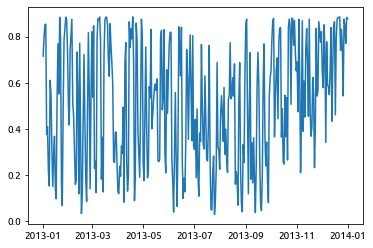

In [27]:
for c in n.iterate_components(n.branch_components|n.controllable_one_port_components):
        if c.name == "Generator":
            print("Gen found")
            gens = c
plt.plot(n.generators_t.p_max_pu["DK1 0 offwind-dc"])


n.buses.carrier.unique()